### 1,2,3. Importing the librairies and data

I took the GDP of the US as the temporal data

In [1]:
import quandl
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import rcParams
rcParams['figure.figsize'] = (9, 6)

quandl.ApiConfig.api_key = "_Z7Y87xWSYCaq7yMzTAM"
# quandl.ApiConfig.api_key = "MEtrho9Abxt9NbtwD43"
TICKER = "FRED/GDP"

In [2]:
data = quandl.get(TICKER)
data.iloc[:10]

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742
1948-04-01,272.567
1948-07-01,279.196
1948-10-01,280.366
1949-01-01,275.034


### 4. Plot a line chart of the data

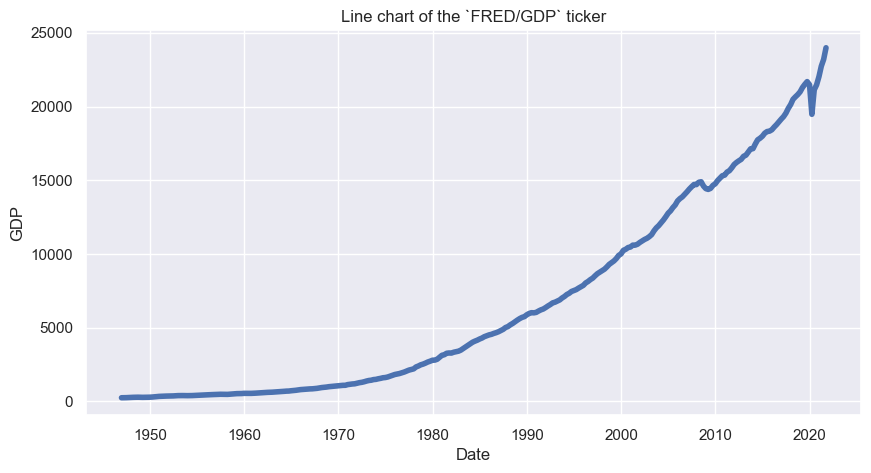

In [3]:
sns.set()
plt.figure(figsize=(10, 5))
plt.title(f"Line chart of the `{TICKER}` ticker")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.plot(data, ls="-", lw=4);

### 5. Decompose the timeseries data

We can observe a strong seasonal component and a nice smooth trend component. 
However, I set a log yscale for the residuals and we can clearly observe that for 2008 and 2021 (respectively the subprime and the covid crisis), there is a break in the seasonnality that is not explained. 

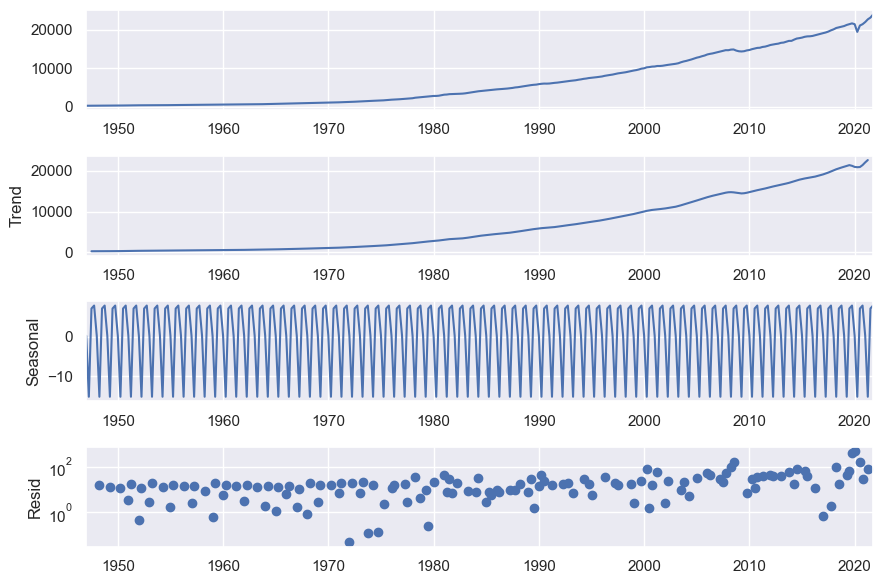

In [4]:
decomposed = sm.tsa.seasonal_decompose(data)
fig = decomposed.plot()
resid_ax = list(filter(lambda ax:ax.get_ylabel() == "Resid", fig.axes))[0]
resid_ax.set_yscale('log')
plt.show()

### 6.1 Dickey-Fuller stationarity test

The *p-value* is clearly not less than 0.05, it is not a significant result in our case. If we take a look at the critical values, they are clearly less than the statistical value, it is thus impossible to reject the null hypothesis and the data is then non-stationnary.

In [5]:
from statsmodels.tsa.stattools import adfuller
from collections import namedtuple

def adfuller_test(data, print_result=False):
    adfuller_result = namedtuple('AdFullerResult', ['adf', 'p_value', 'used_lag', 'n_obs', 'critical_values', 'ic_best'])
    result = adfuller_result(*adfuller(data, autolag='AIC'))
    if print_result:
        print('ADF Statistic: %f' % result.adf)
        print('p-value: %f' % result.p_value)
        print('Critical Values:')
        for key, value in result.critical_values.items():
            print('\t%s: %.3f' % (key, value))
    return result

result = adfuller_test(data, print_result=True)

ADF Statistic: 5.254722
p-value: 1.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


### 6.2 Autocorrelation stationarity test

If we check once again with the autocorrelation, we can't say that our data is non stationnary as the confidence level doesn't cross the lags, so we can't conclude anything here but as the *p-value* of the Dickey-Fuller is maximal, the data seems to be strongly non-stationnary.

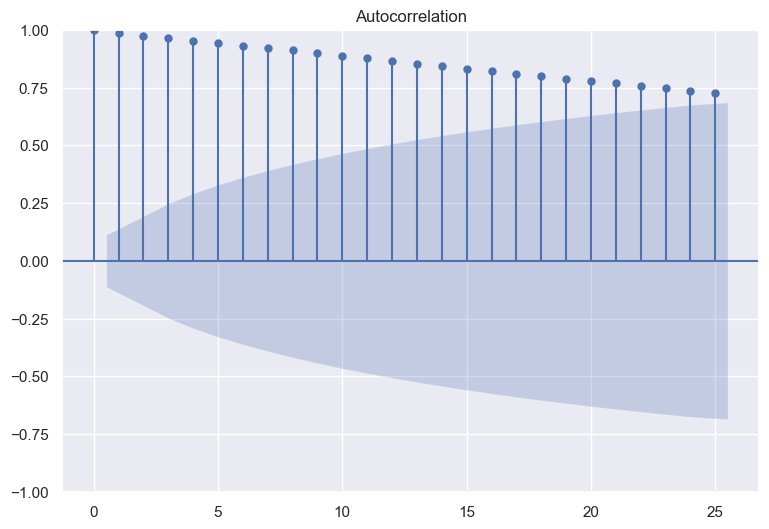

In [6]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data)
plt.show()

### 7. Differencing

By one round of differencing, we see that we HEAD towards the good direction as the statistical value and the p-value decrease, let's see how it will go with several rounds of differencing

In [7]:
data_diff = data.diff()
data_diff.dropna(inplace=True)

result = adfuller_test(data_diff, print_result=True)

ADF Statistic: -1.554274
p-value: 0.506512
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


### 8. Rounds of differencing

After only 2 rounds of differenciation, we obtained stationnary data with a p-value of $2.22 e^{-11}$.

In [8]:
from itertools import count
from pprint import pprint

data_diff = data
result = adfuller_test(data)
for n_diff in count():
    if result.p_value < .05:
        break
    data_diff = data_diff.diff().dropna()
    result = adfuller_test(data_diff)

print(f"We obtained a p-value of {result.p_value:.3e} after {n_diff} differentiations")
pprint(dict(**result._asdict()))

We obtained a p-value of 2.221e-11 after 2 differentiations
{'adf': -7.613624752886905,
 'critical_values': {'1%': -3.4538376962008495,
                     '10%': -2.5722803076202174,
                     '5%': -2.8718811911083093},
 'ic_best': 3719.4850831845315,
 'n_obs': 281,
 'p_value': 2.221370261069014e-11,
 'used_lag': 16}


### 9. Autocorrelation the data diff

We can see that the lag at 0 is the strongest, which is great as the data is fully correlated with itself. We only have a little correlation for the lag at index 1 but the confidence interval is really low for this one so that's not a problem. For all the other lags, we have tiny values which means that the data shifted by these indexes are not strongly correlated with the data.

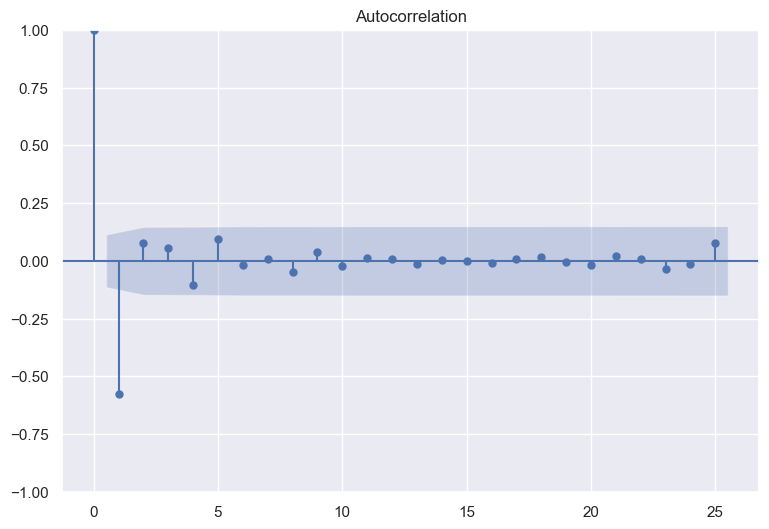

In [9]:
plot_acf(data_diff)
plt.show()